# Code examples for complex figures

This notebook first loads a data file `LightIntensityData.csv` and demonstrates a nonlinear fit on it, and then subsequently shows multiple examples of complex figures that could be plotted based on the data, fit and residuals

## Loading and fitting the data

First load relevant libraries, the data and the fitting function.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Definition of the fit function
#   The model is an inverse-square law with correction for near-field effects
#   k: the overall light intensity
#   l: the estimate of the length of the filament in metres.
def fit_function(x, k, l):
    return 2*k/l*np.arctan(l/(2*x))/x

def fit_dydx(x, k, l):
    # Used Wolfram alpha to differentiate the function above
    return k*(-4/(x*(l**2+4*x**2))-(2*np.arctan(l/(2*x)))/(l*x**2))

# Load the data
#   fname is assumed to be a .csv file (comma separated values). All rows 
#   containing non-number text (example: names for each column) must begin 
#   with "#". 
fname = 'LightIntensityData.csv'

# The data file fname has x data (first column) and y data (third column) and 
# the uncertianty in x and y (second and fourth column).
# Enter the name and units of each column here so that the plots are properly
x_name = 'Distance'
x_units = 'metres'
y_name = 'Intensity'
y_units = 'Watts/m^2'

# load the file "fname", defined above
data = np.loadtxt(fname, delimiter=',', comments='#',usecols=(0,1,2,3))

# Access the data columns and assign variables x,y  and  y_sigma
x = data[:,0]
y = data[:,2]
x_sigma = data[:,1]
y_sigma = data[:,3]


Make an initial plot of the data so that reasonable initital guesses for fitting parameters. We will do this on a log-log scale since we are expecting the overall behaviour to be like a power law (inverse-square law), with corrections

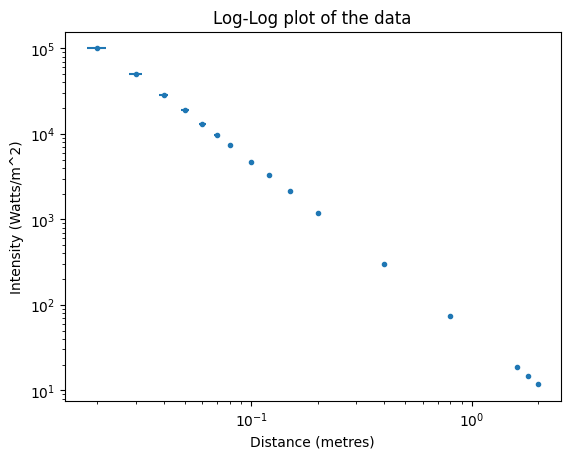

In [2]:

#compares the guessed curve to the data for visual reference
plt.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='')
plt.xlabel(f'{x_name} ({x_units})')
plt.ylabel(f'{y_name} ({y_units})')
plt.xscale('log')
plt.yscale('log')
plt.title('Log-Log plot of the data')
plt.show()

Now make some initial guesses of the fitting parameters and plot the resulting model with the data

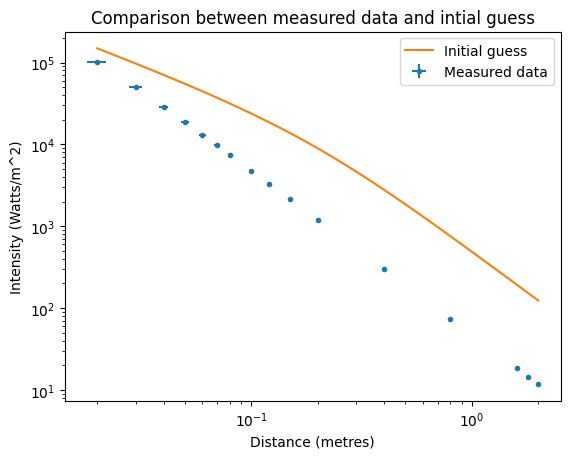

In [3]:
# Initial guesses for the fitting parameters
guesses = (500., 0.5)

# Define the x-values to be used for plotting the model
x_model = np.linspace(min(x),max(x),200)

# Find the y_model values using guesses at the x-values correponding to x_model
y_model = fit_function(x_model, *guesses)

# Graph the results
plt.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='', label="Measured data")
plt.plot(x_model, y_model, marker="", label="Initial guess")
plt.xlabel(f'{x_name} ({x_units})')
plt.ylabel(f'{y_name} ({y_units})')
plt.title('Comparison between measured data and intial guess')
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.show()

Now make some initial guesses of the fitting parameters and plot the resulting model with the data

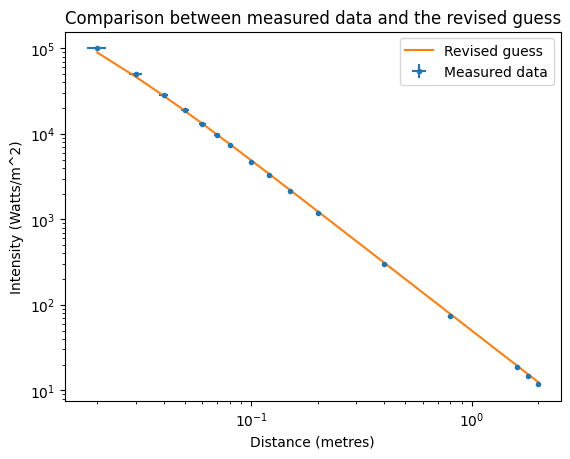

In [4]:
# Revise our guesses for the fitting parameters
guesses = (50., 0.05)

# Find the y_model values using guesses at the x-values correponding to x_model
y_model = fit_function(x_model, *guesses)

# Graph the results
plt.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='', label="Measured data")
plt.plot(x_model, y_model, marker="", label="Revised guess")
plt.xlabel(f'{x_name} ({x_units})')
plt.ylabel(f'{y_name} ({y_units})')
plt.title('Comparison between measured data and the revised guess')
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.show()

We will use the method of combining the x- and y- uncertainties into an overall y-uncertainty ($\sigma_{tot}$) for the purposes of fitting, which involves converting $\delta x$ into a an effective $\delta y_{eff}$ using the local slope at that point (aka the derivative of the fit function):

$$\delta y_{eff} = \frac{df}{dx}\delta x$$

In [5]:
# The total y-uncertainty is the sum (in quadrature) of the measured y uncertainty
# and the x uncertainty times the derivative of the model.
# Note, the whole fit should be iterated if your initial guess is far off of the final fit values

# First get the slope at using the current parameter guesses
dydx = fit_dydx(x,*guesses)

# then determine the overall uncertainty
sigma_tot = np.sqrt( y_sigma**2 + (dydx * x_sigma)**2 )

###############################################################################
# Perform the fit
###############################################################################
                    
# Fit the data to fit_function. fit_params is the resultant parameters, fit_cov
# is the covariance matrix between all the parameters. maxfev=10**5 means the
# fitting procedure is iterated at maximum 10^5 times before giving up.
fit_params, fit_cov = curve_fit(fit_function, x, y, 
    sigma=sigma_tot, p0=guesses, absolute_sigma=True, maxfev=10**5)
                            
###############################################################################
# Output chi-squared
###############################################################################

# Function that  calculates the chi square value of a fit
def chi_square (fit_parameters, x, y, sigma):
    dof = len(x) - len(fit_parameters)
    return np.sum((y-fit_function(x, *fit_parameters))**2/sigma**2)/dof
    
# calculate and print chi square as well as the per degree-of-freedom value
chi2 = chi_square(fit_params,x,y,sigma_tot)
print ("*** Results for revised guess for the fitting parameters***")
print ("Goodness of fit - chi square measure:")
print (f"  Chi2 = {chi2:.3}")


###############################################################################
# Output fit parameters (with uncertainty)
###############################################################################

# Calculate the standard deviation as uncertainty of the fit parameters
fit_params_error = np.sqrt(np.diag(fit_cov))

# read out parameter results
param_names = ['Intensity of Lamp','Length of Filament']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print (f"  {param_names[i]} = {fit_params[i]:.5} ± {fit_params_error[i]:.3}")

###############################################################################
# Rerun the fit using the output fit parameters as the final guess 
###############################################################################

guesses = fit_params
dydx = fit_dydx(x,*guesses)
sigma_tot = np.sqrt( y_sigma**2 + (dydx * x_sigma)**2 )
fit_params, fit_cov = curve_fit(fit_function, x, y, 
    sigma=sigma_tot, p0=guesses, absolute_sigma=True, maxfev=10**5)
                                                                                      
# Chi-2
chi2 = chi_square(fit_params,x,y,sigma_tot)
print ("\n*** Results for final iterated guess for the fitting parameters***")
print ("Goodness of fit - chi square measure:")
print (f"  Chi2 = {chi2:.3}")

# Output parameter results
fit_params_error = np.sqrt(np.diag(fit_cov))
param_names = ['Intensity of Lamp','Length of Filament']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print (f"  {param_names[i]} = {fit_params[i]:.5} ± {fit_params_error[i]:.3}")

*** Results for revised guess for the fitting parameters***
Goodness of fit - chi square measure:
  Chi2 = 0.524
Fit parameters:
  Intensity of Lamp = 47.194 ± 0.0921
  Length of Filament = 0.023823 ± 0.0122

*** Results for final iterated guess for the fitting parameters***
Goodness of fit - chi square measure:
  Chi2 = 0.56
Fit parameters:
  Intensity of Lamp = 47.197 ± 0.0896
  Length of Filament = 0.021238 ± 0.0162


We will look at the quality of the fit using various plots below, but first need to ensure that all of our variables to plot are as we need them

In [6]:
# The final values for y_model
y_model = fit_function(x_model, *fit_params)

# The residuals
residual = y - fit_function(x, *fit_params)

## 2-Panel plot using regular axes (linear-linear) and saving a graph

This code produces a two-part figure where the x-axis is shared. The code assumes you have defined many of the things defined above

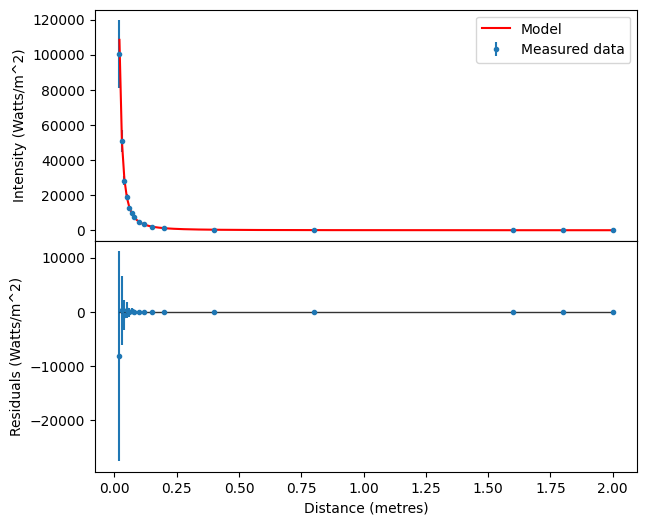

In [7]:
# Sets up a figure with two parts stacked vertically and shared x-axis scale 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6))

# The first subplot: plot of data and a fit finction
#ax[0].errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='', label="Measured data")
ax[0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0].set_ylabel(f'{y_name} ({y_units})')
ax[0].legend(loc='best')

# The second subplot: residuals
ax[1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
#ax[1].errorbar(x, residual, xerr=x_sigma, yerr=y_sigma,marker='.',linestyle='')
ax[1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1].set_xlabel(f'{x_name} ({x_units})')
ax[1].set_ylabel(f'Residuals ({y_units})')

plt.subplots_adjust(hspace=0) # Remove space between the subplots
plt.savefig('graph.png') # This will save a copy of the graph into your working directory
plt.show()

## 2-Panel plot using log-log axes

This code produces a two-part figure where the x-axis is shared and log-log axes are used for the main plot. The code assumes you have defined many of the things defined above

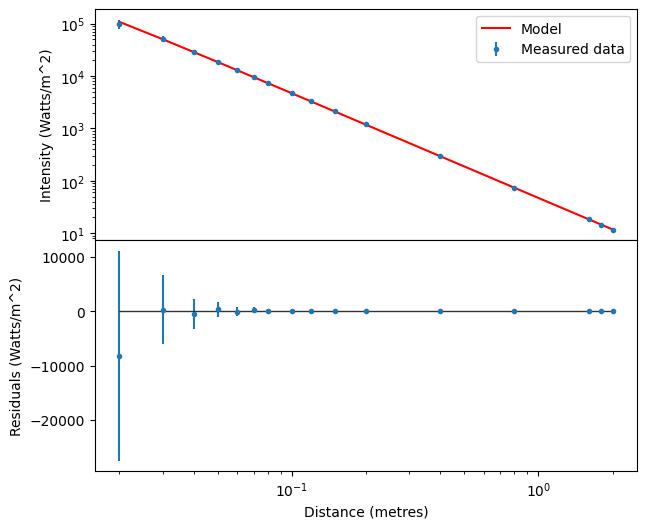

In [8]:
# Sets up a figure with two parts stacked vertically and shared x-axis scale 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6))

# The first subplot: plot of data and a fit finction
#ax[0].errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='', label="Measured data")
ax[0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0].set_ylabel(f'{y_name} ({y_units})')
ax[0].legend(loc='best')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# The second subplot: residuals
ax[1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
#ax[1].errorbar(x, residual, xerr=x_sigma, yerr=y_sigma,marker='.',linestyle='')
ax[1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1].set_xlabel(f'{x_name} ({x_units})')
ax[1].set_ylabel(f'Residuals ({y_units})')

plt.subplots_adjust(hspace=0) # Remove space between the subplots
plt.show()

## 2-Panel plot with inset

This code produces a two-part figure where the x-axis is shared and the first panel has an inset. 

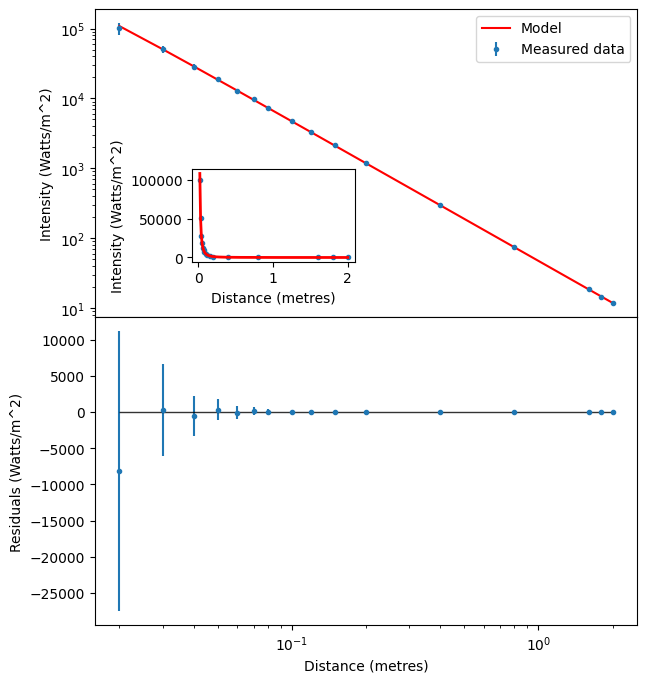

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

# Sets up a figure with two parts stacked vertically and shared x-axis scale 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

# The first subplot: plot of data and a fit function
ax[0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0].plot(x_model, y_model, marker="", color="r", label="Model")
ax[0].set_ylabel(f'{y_name} ({y_units})')
ax[0].legend(loc='best')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# The second subplot: residuals
ax[1].errorbar(x, residual, yerr=sigma_tot, marker='.', linestyle='')
ax[1].hlines(0, np.min(x), np.max(x), lw=1, alpha=0.8, color="k")
ax[1].set_xlabel(f'{x_name} ({x_units})')
ax[1].set_ylabel(f'Residuals ({y_units})')

# Create an inset Axes: this should fill the bounding box allocated to it.
inset = ax[0].inset_axes([0.18, 0.18, 0.30, 0.30])
inset.errorbar(x, y, yerr=y_sigma, marker='.', linestyle='', label="Measured data")
inset.errorbar(x_model, y_model, marker="", linestyle="-", linewidth=2, color="r", label="Fit")
inset.set_xlabel(f'{x_name} ({x_units})')
inset.set_ylabel(f'{y_name} ({y_units})')

plt.subplots_adjust(hspace=0) # Remove space between the subplots
plt.show()

## 4-Panel plot with shared x- and y-axes

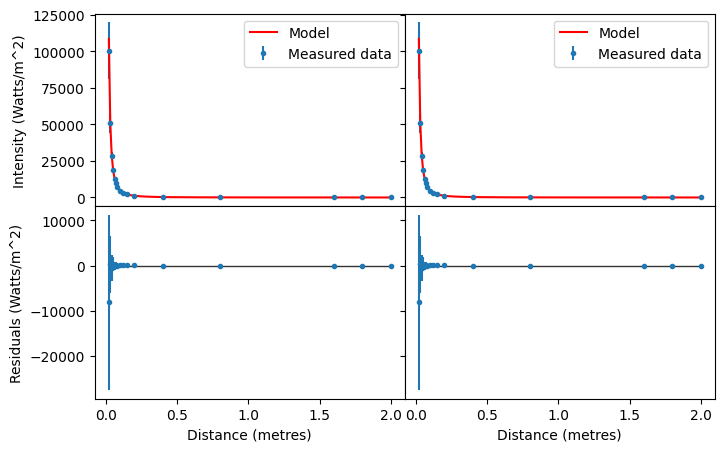

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')

# The upper-left subplot: plot of data and a fit finction
ax[0,0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,0].set_ylabel(f'{y_name} ({y_units})')
ax[0,0].legend(loc='best')

# The lower-left subplot: residuals
ax[1,0].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,0].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1,0].set_xlabel(f'{x_name} ({x_units})')
ax[1,0].set_ylabel(f'Residuals ({y_units})')

# The upper-right subplot: plot of data and a fit finction
ax[0,1].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,1].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,1].legend(loc='best')

# The lower-right subplot: residuals
ax[1,1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1,1].set_xlabel(f'{x_name} ({x_units})')

plt.show()

## 4-Panel plot with independent y-axes and shared x-axes within column

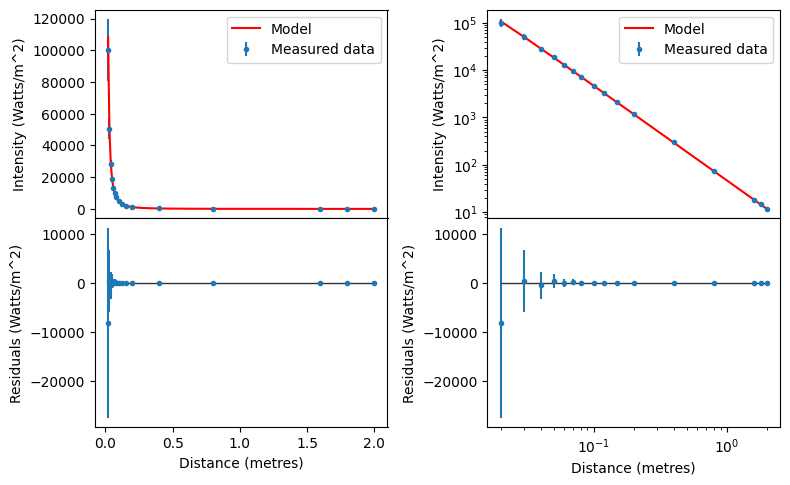

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(8, 5))

# The upper-left subplot: plot of data and a fit finction
ax[0,0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,0].set_ylabel(f'{y_name} ({y_units})')
ax[0,0].legend(loc='best')

# The lower-left subplot: residuals
ax[1,0].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,0].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1,0].set_xlabel(f'{x_name} ({x_units})')
ax[1,0].set_ylabel(f'Residuals ({y_units})')

# The upper-right subplot: plot of data and a fit finction
ax[0,1].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,1].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,1].set_ylabel(f'{y_name} ({y_units})')
ax[0,1].legend(loc='best')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')

# The lower-right subplot: residuals
ax[1,1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1,1].set_xlabel(f'{x_name} ({x_units})')
ax[1,1].set_xscale('log')
ax[1,1].set_ylabel(f'Residuals ({y_units})')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

## 4-Panel plot with independent axes

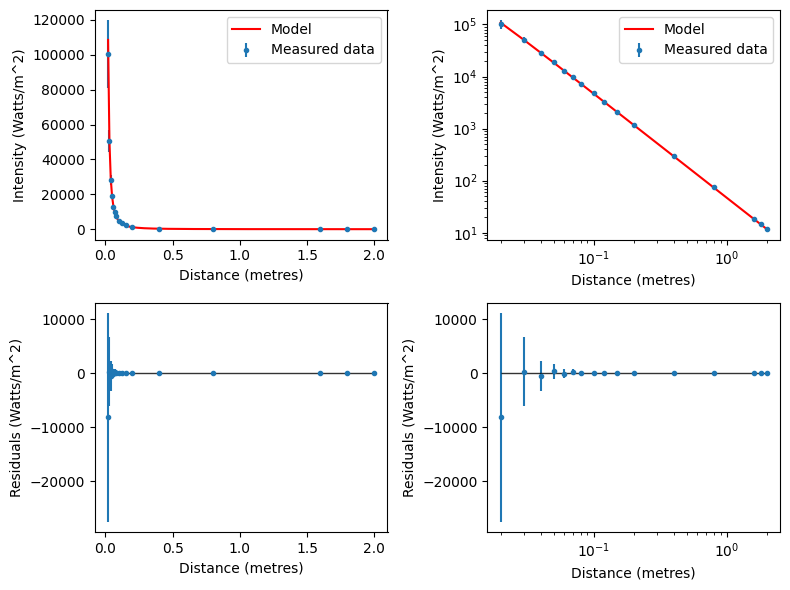

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# The upper-left subplot: plot of data and a fit finction
ax[0,0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,0].set_xlabel(f'{x_name} ({x_units})')
ax[0,0].set_ylabel(f'{y_name} ({y_units})')
ax[0,0].legend(loc='best')

# The lower-left subplot: residuals
ax[1,0].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,0].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1,0].set_xlabel(f'{x_name} ({x_units})')
ax[1,0].set_ylabel(f'Residuals ({y_units})')

# The upper-right subplot: plot of data and a fit finction
ax[0,1].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,1].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,1].set_xlabel(f'{x_name} ({x_units})')
ax[0,1].set_ylabel(f'{y_name} ({y_units})')
ax[0,1].legend(loc='best')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')

# The lower-right subplot: residuals
ax[1,1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1,1].set_xlabel(f'{x_name} ({x_units})')
ax[1,1].set_xscale('log')
ax[1,1].set_ylabel(f'Residuals ({y_units})')

plt.tight_layout()
plt.show()